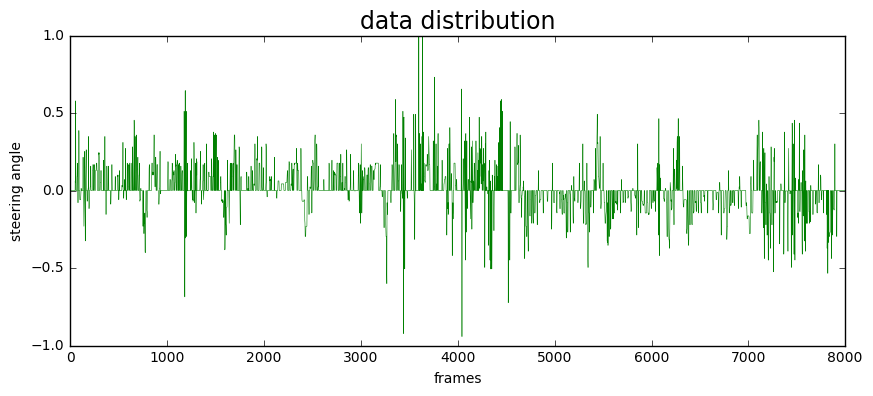

In [1]:
"""
 
import tensorflow as tf
 
 
import os, sys

from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Input, ELU
from keras import initializations
from keras.models import load_model, model_from_json
from keras.layers.normalization import BatchNormalization
from sklearn.utils import shuffle
from keras import backend as K
import json
import gc
"""
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2
csv_path = 'driving_log.csv'  # my data
csv_path1 = 'data/driving_log.csv'  # udacity data
 
center_db, left_db, right_db, steer_db = [], [], [], []
Rows, Cols = 64, 64
offset = 0.22

# read csv file
with open(csv_path1) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        center_db.append(row['center'])
        left_db.append(row['left'])
        right_db.append(row['right'])
        steer_db.append(float(row['steering']))
        """
        if float(row['steering']) != 0.0:
            center_db.append(row['center'])
            left_db.append(row['left'])
            right_db.append(row['right'])
            steer_db.append(float(row['steering']))
        else:
            prob = np.random.uniform()
            if prob <= 0.1:
                center_db.append(row['center'])
                left_db.append(row['left'])
                right_db.append(row['right'])
                steer_db.append(float(row['steering']))
         """
plt.figure(figsize=(10,4))
x = [range(len(steer_db))]
x = np.squeeze(np.asarray(x))
y = np.asarray(steer_db)
plt.xlim(0,8000)
plt.title('data distribution', fontsize=17)
plt.xlabel('frames')
plt.ylabel('steering angle')
plt.plot(x,y, 'g', linewidth=0.4)
plt.show()

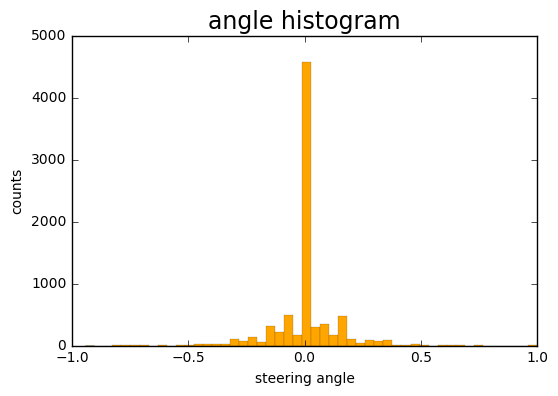

In [2]:
plt.hist(steer_db, bins= 50, color= 'orange', linewidth=0.1)
plt.title('angle histogram', fontsize=17)
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()

In [3]:
def read_img(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

num = 300
center_img, center_steering = read_img(center_db[num]), steer_db[num]
left_img, left_steering = read_img(left_db[num]), steer_db[num] + offset
right_img, right_steering = read_img(right_db[num]), steer_db[num] - offset

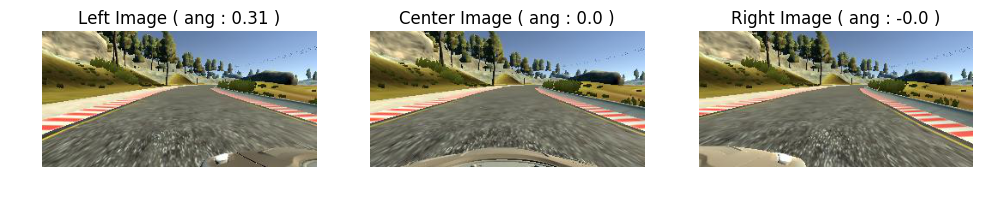

In [4]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(left_img)
plt.title('Left Image ( ang : ' + str(np.round(left_steering,3)) + ' )')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(center_img)
plt.title('Center Image ( ang : ' + str(np.round(center_steering)) + ' )')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(right_img)
plt.title('Right Image ( ang : ' + str(np.round(right_steering)) + ' )')
plt.axis('off')
plt.show()

In [5]:
def shift_img(image, steer):
    """
    randomly shift image horizontally
    add proper steering angle to each image
    """
    max_shift = 55
    max_ang = 0.14  # ang_per_pixel = 0.0025

    rows, cols, _ = image.shape

    random_x = np.random.randint(-max_shift, max_shift + 1)
    dst_steer = steer + (random_x / max_shift) * max_ang
    if abs(dst_steer) > 1:
        dst_steer = -1 if (dst_steer < 0) else 1

    mat = np.float32([[1, 0, random_x], [0, 1, 0]])
    dst_img = cv2.warpAffine(image, mat, (cols, rows))
    return dst_img, dst_steer

def brightness_img(image):
    """
    randomly change brightness by converting Y value
    """
    br_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    coin = np.random.randint(2)
    if coin == 0:
        random_bright = 0.2 + np.random.uniform(0.2, 0.6)
        br_img[:, :, 2] = br_img[:, :, 2] * random_bright
    br_img = cv2.cvtColor(br_img, cv2.COLOR_HSV2RGB)
    return br_img

def generate_shadow(image, min_alpha=0.5, max_alpha = 0.75):
    """generate random shadow in random region"""

    top_x, bottom_x = np.random.randint(0, Cols, 2)
    coin = np.random.randint(2)
    rows, cols, _ = image.shape
    shadow_img = image.copy()
    if coin == 0:
        rand = np.random.randint(2)
        vertices = np.array([[(50, 65), (45, 0), (145, 0), (150, 65)]], dtype=np.int32)
        if rand == 0:
            vertices = np.array([[top_x, 0], [0, 0], [0, rows], [bottom_x, rows]], dtype=np.int32)
        elif rand == 1:
            vertices = np.array([[top_x, 0], [cols, 0], [cols, rows], [bottom_x, rows]], dtype=np.int32)
        mask = image.copy()
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (0,) * channel_count
        cv2.fillPoly(mask, [vertices], ignore_mask_color)
        rand_alpha = np.random.uniform(min_alpha, max_alpha)
        cv2.addWeighted(mask, rand_alpha, image, 1 - rand_alpha, 0., shadow_img)

    return shadow_img

def flip_img(image, steering):
    """ randomly flip image to gain right turn data (track1 is biaed in left turn) """
    flip_image = image.copy()
    flip_steering = steering
    num = np.random.randint(2)
    if num == 0:
        flip_image, flip_steering = cv2.flip(image, 1), -steering
    return flip_image, flip_steering

In [35]:
flip_image, flip_steer = flip_img(center_img, center_steering)
shift_image, shift_steer = shift_img(center_img, center_steering)
brightness_image = brightness_img(center_img)
shadow_image = generate_shadow(center_img)

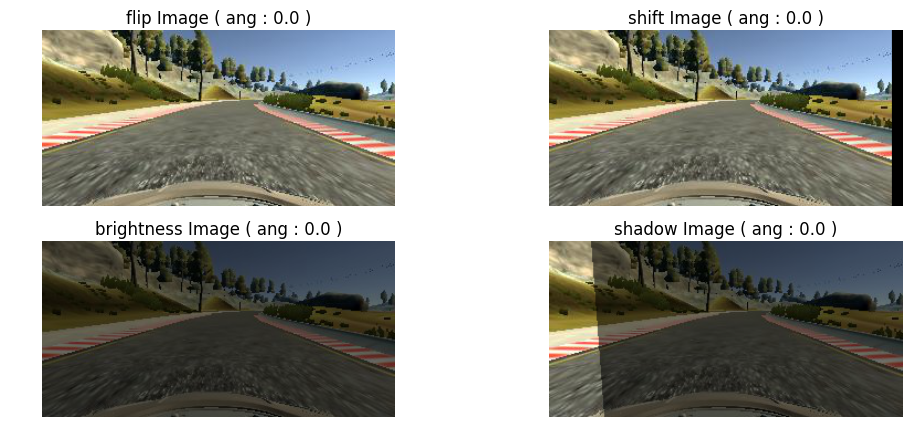

In [36]:
plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.imshow(flip_image)
plt.title('flip Image ( ang : ' + str(np.round(flip_steer)) + ' )')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(shift_image)
plt.title('shift Image ( ang : ' + str(np.round(shift_steer)) + ' )')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(brightness_image)
plt.title('brightness Image ( ang : ' + str(np.round(center_steering)) + ' )')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(shadow_image)
plt.title('shadow Image ( ang : ' + str(np.round(center_steering)) + ' )')
plt.axis('off')
plt.show()

In [45]:
def select_img(center, left, right, steer, num, offsets=0.22):
    """
    randomly select among center, left, right images

    add ±0.22 to left, right steering angle.
    couldn't find exact left, right steering angle by using geometric method because we didn't have enough information.
    """
    rand = np.random.randint(3)

    if rand == 0:
        image, steering = cv2.imread(center[num]), steer[num]
    elif rand == 1:
        image, steering = cv2.imread(left[num]), steer[num] + offsets
    elif rand == 2:
        image, steering = cv2.imread(right[num]), steer[num] - offsets
    if abs(steering) > 1:
        steering = -1 if (steering < 0) else 1

    return image, steering

def crop_img(image):
    """ crop unnecessary parts """
    cropped_img = image[63:136, 0:319]
    resized_img = cv2.resize(cropped_img, (Cols, Rows), cv2.INTER_AREA)
    img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    return img

def generate_train(center, left, right, steer):
    """ image preprocessing & augment """

    num = np.random.randint(0, len(steer))

    image, steering = select_img(center, left, right, steer, num, offset)

    image, steering = shift_img(image, steering)
    image, steering = flip_img(image, steering)
    image = brightness_img(image)
    #image = generate_shadow(image)
    image = crop_img(image)
    return image, steering

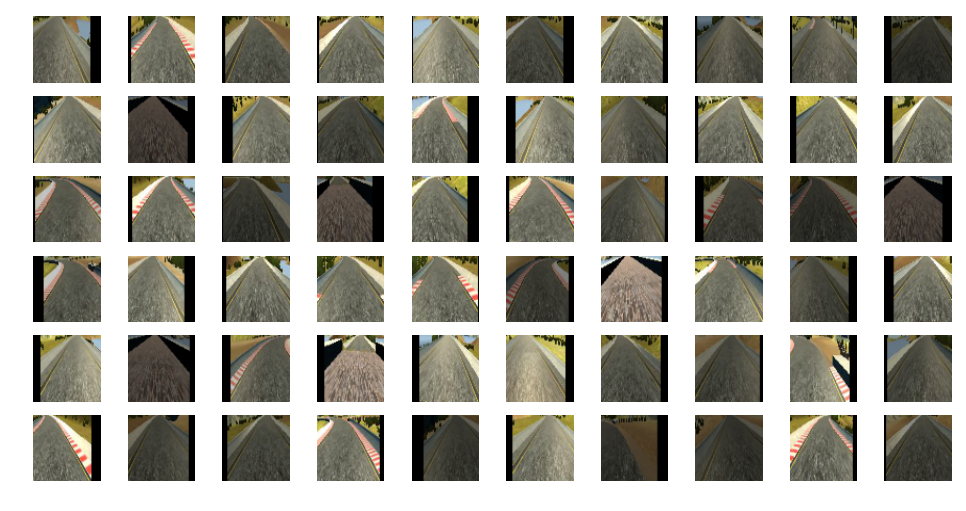

In [53]:
plt.figure(figsize=(12,6))
for i in range(60):
    image,steer = generate_train(center_db, left_db, right_db, steer_db)
    
    plt.subplot(6,10,i+1)
    plt.imshow(image);
    plt.axis('off')
plt.show()

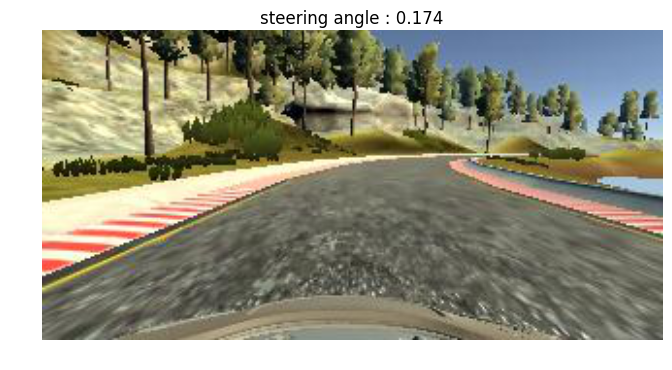

In [70]:
from keras.models import Sequential, Model
from keras.models import load_model, model_from_json
import json

with open('model.json', 'r') as jfile:
    model = model_from_json(json.load(jfile))
model.load_weights('./model.h5')

layer1 = Model(input=model.input, output=model.get_layer('Conv1').output)
layer2 = Model(input=model.input, output=model.get_layer('Conv2').output)

img_path = 'center_2016_12_01_13_38_51_331.jpg'
img = cv2.imread(img_path)
img = crop_img(img)
img = np.expand_dims(img, axis=0)
steering = model.predict(img)
visual_layer1, visual_layer2 = layer1.predict(img), layer2.predict(img)

arr_1, arr_2, layer_1, layer_2 = [], [], [], []
for i in range(32):
    arr_1.append(visual_layer1[0, :, :, i])
for i in range(64):
    arr_2.append(visual_layer2[0, :, :, i])
    
plt.figure(figsize=(8,4))
plt.plot()
plt.imshow(plt.imread(img_path))
plt.title('steering angle : '+ str(np.round(float(steering),3)))
plt.axis('off')
plt.show()

layer 1 feature map


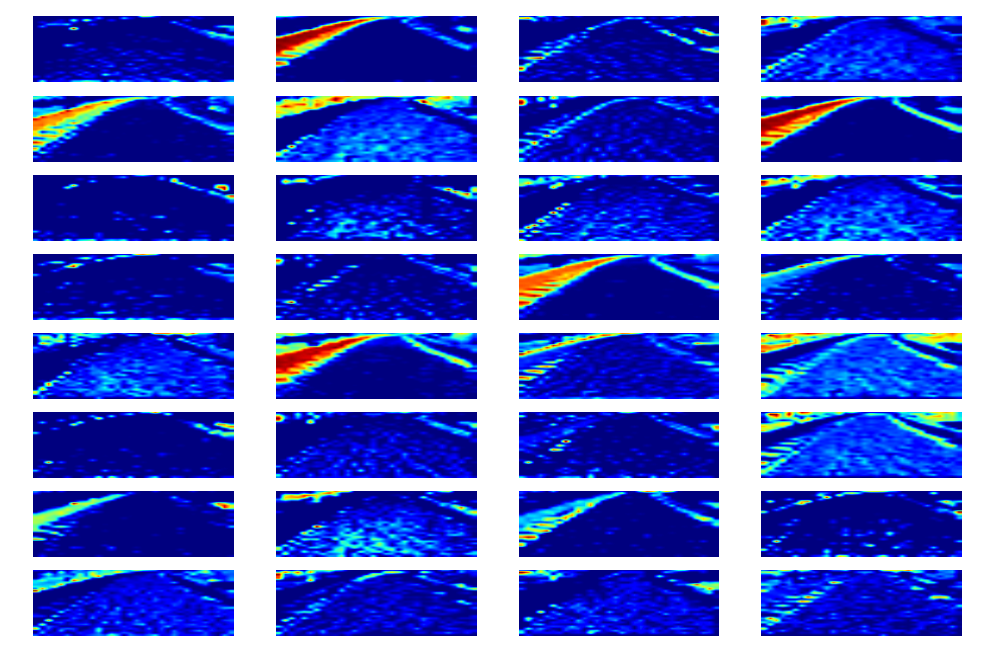

In [71]:
print("layer 1 feature map")

plt.figure(figsize=(12,8))
for i in range(32):
    plt.subplot(8, 4, i+1)
    temp = arr_1[i]
    temp = cv2.resize(temp, (200, 66), cv2.INTER_AREA)
    plt.imshow(temp)
    plt.axis('off')
plt.show()

layer 2 feature map


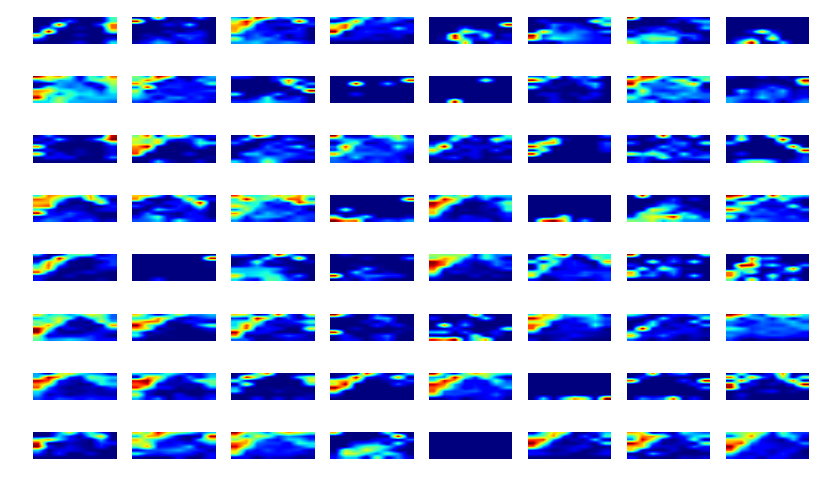

In [78]:
print("layer 2 feature map")

plt.figure(figsize=(10,6))
for i in range(64):
    plt.subplot(8, 8, i+1)
    temp = arr_2[i]
    temp = cv2.resize(temp, (200, 66), cv2.INTER_AREA)
    plt.imshow(temp)
    plt.axis('off')
plt.show()